In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
SAVE_PATH = './path/to/data/'

class Net(nn.Module):
    def __init__(self, dataset_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
        


    
        



In [2]:
class DataGen(Dataset):
    def __init__(self):
        np.random.seed(45)
        self.npts_src = 500
        self.noisy = 100
        self.npts_tgt = 50
        self.npts_test = 50
        self.data = np.random.uniform([-1.0], [1.0], (self.npts_src,2)).astype(np.float32)
        self.labels = np.zeros(self.npts_src)
        self.labels[np.where(self.data[:,0] > 0.0)] = 1
        self.rand_ind = np.random.randint(0, self.npts_src, self.noisy)
        self.labels[self.rand_ind] = 1 -  self.labels[self.rand_ind]
        
        self.tgt_data = np.random.uniform([-1.0], [1.0], (self.npts_tgt,2)).astype(np.float32)
        self.tgt_data = torch.tensor(self.tgt_data)
        self.tgt_labels = np.zeros(self.npts_tgt)
        self.tgt_labels[np.where(self.tgt_data[:,0] > 0.0)] = 1
        self.tgt_labels = torch.tensor(self.tgt_labels, dtype=torch.long)
        
        self.test_data = np.random.uniform([-1.0], [1.0], (self.npts_test,2)).astype(np.float32)
        self.test_data = torch.tensor(self.test_data)
        self.test_labels = np.zeros(self.npts_test)
        self.test_labels[np.where(self.test_data[:,0] > 0.0)] = 1
        self.test_labels = torch.tensor(self.test_labels, dtype=torch.long)
        
    def __len__(self):
        'Denotes the total number of samples'
        return self.npts_src
    
    def __getitem__(self, idx):
        'Generates one sample of data'
        # Select sample
        sample = torch.from_numpy(self.data[idx, :])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label, idx



In [3]:
def train(model, device, train_loader, optimizer, epoch, alpha=None, alpha_lr=5.0):
    model.train()
    tgt_data = train_loader.dataset.tgt_data.to(device)
    tgt_target = train_loader.dataset.tgt_labels.to(device)
    if alpha is None:
        alpha = 0.5*torch.ones(len(train_loader.dataset), requires_grad=False).to(device)
    
    for batch_idx, (data, target, idx) in enumerate(train_loader):
        
        # run target set throught network to get target gradient        
        tgt_output = model(tgt_data)
        tgt_loss = F.nll_loss(tgt_output, tgt_target)        
        for param in model.parameters():
            if param.grad is not None:                
                param.grad.data.zero_()
        tgt_loss.backward()
        with torch.no_grad():
            tgt_grad = torch.cat([x.grad.data.view(-1).clone() for x in model.parameters()])
        
        # run source set throught network to get source gradient        
        data, target = data.to(device), target.to(device)                
        output = model(data)
        bsize = data.shape[0]
        src_loss = F.nll_loss(output, target, reduction='none')  # no reduction to allow individual grads        
        
        # compute the modified grad
        grads_accum = torch.zeros_like(tgt_grad, requires_grad=False, device=device)
        for i, loss_i in enumerate(src_loss):
            for param in model.parameters():
                param.grad.data.zero_()
            loss_i.backward(retain_graph=True)  # flag allowes re-backprop
            with torch.no_grad():
                curr_grad = torch.cat([x.grad.data.view(-1).clone() for x in model.parameters()])            
            q = curr_grad.dot(tgt_grad)
            alpha[idx[i]] += alpha_lr * q * optimizer.param_groups[0]['lr']
            alpha[idx[i]] = torch.clamp(alpha[idx[i]], 0.0, 1.0)
            grads_accum += alpha[idx[i]] * curr_grad / (1.0*bsize)
        
        # set model grads 
        with torch.no_grad():
            sizes = [x.nelement() for x in model.parameters()]
            for g, p in zip(grads_accum.split(sizes), model.parameters()):        
                p.grad = g.view(p.size())                
                
        # now we can finally take a gradient step                    
        optimizer.step()
             

        if batch_idx % 10 == 0:            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tTgtLossL {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                src_loss.sum().item(),
                tgt_output.argmax(1).eq(tgt_target).sum().item())) 
            
            
    return alpha

#tgt_output.argmax(1).eq(tgt_target).sum().item()

In [4]:
params = {'batch_size': 16,
          'num_workers': 1,
          'lr': 0.01,
          'momentum': 0.5,
          'alpha_lr': 20,
          'epochs': 100}  
use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = DataLoader(DataGen(), batch_size=params['batch_size'], shuffle=True,
                          num_workers=params['num_workers'],
                          pin_memory=True)

# test_loader = DataLoader(DataGen(), batch_size=params['batch_size'], shuffle=False,
#                         num_workers=params['num_workers'], pin_memory=True)

model = Net(len(train_loader.dataset)).cuda() if use_cuda else Net()
optimizer = optim.SGD(model.parameters(), lr=params['lr'], momentum=params['momentum'])

In [5]:
# # evaluate
def test(model, device, train_loader):
    model.eval()
    data = train_loader.dataset.test_data
    target = train_loader.dataset.test_labels
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        test_output = model(data)
        
    print(test_output.argmax(1).eq(target).sum().item())

In [6]:
a_list = []
model.train()
a = None
for epoch in range(1, params['epochs'] + 1):    
    a = train(model, device, train_loader, optimizer, epoch, a, alpha_lr=params['alpha_lr'])
    test(model, device, train_loader)
    a_list.append(a.clone().detach().cpu().numpy())


Train Epoch: 1 [0/500 (0%)]	Loss: 11.203958 	TgtLossL 28.000000
Train Epoch: 1 [160/500 (31%)]	Loss: 10.828979 	TgtLossL 28.000000
Train Epoch: 1 [320/500 (62%)]	Loss: 10.698404 	TgtLossL 28.000000
Train Epoch: 1 [480/500 (94%)]	Loss: 11.675474 	TgtLossL 28.000000
23
Train Epoch: 2 [0/500 (0%)]	Loss: 11.241352 	TgtLossL 28.000000
Train Epoch: 2 [160/500 (31%)]	Loss: 10.978185 	TgtLossL 28.000000
Train Epoch: 2 [320/500 (62%)]	Loss: 11.472946 	TgtLossL 28.000000
Train Epoch: 2 [480/500 (94%)]	Loss: 10.486679 	TgtLossL 28.000000
23
Train Epoch: 3 [0/500 (0%)]	Loss: 9.945841 	TgtLossL 28.000000
Train Epoch: 3 [160/500 (31%)]	Loss: 11.075908 	TgtLossL 28.000000
Train Epoch: 3 [320/500 (62%)]	Loss: 11.739446 	TgtLossL 28.000000
Train Epoch: 3 [480/500 (94%)]	Loss: 10.646384 	TgtLossL 28.000000
23
Train Epoch: 4 [0/500 (0%)]	Loss: 11.742909 	TgtLossL 28.000000
Train Epoch: 4 [160/500 (31%)]	Loss: 10.656774 	TgtLossL 28.000000
Train Epoch: 4 [320/500 (62%)]	Loss: 11.575486 	TgtLossL 28.000000

Train Epoch: 31 [320/500 (62%)]	Loss: 11.763945 	TgtLossL 40.000000
Train Epoch: 31 [480/500 (94%)]	Loss: 8.814089 	TgtLossL 40.000000
39
Train Epoch: 32 [0/500 (0%)]	Loss: 11.605834 	TgtLossL 40.000000
Train Epoch: 32 [160/500 (31%)]	Loss: 10.325599 	TgtLossL 40.000000
Train Epoch: 32 [320/500 (62%)]	Loss: 9.001096 	TgtLossL 40.000000
Train Epoch: 32 [480/500 (94%)]	Loss: 7.810032 	TgtLossL 41.000000
41
Train Epoch: 33 [0/500 (0%)]	Loss: 10.074102 	TgtLossL 41.000000
Train Epoch: 33 [160/500 (31%)]	Loss: 9.898863 	TgtLossL 41.000000
Train Epoch: 33 [320/500 (62%)]	Loss: 9.235901 	TgtLossL 41.000000
Train Epoch: 33 [480/500 (94%)]	Loss: 12.970200 	TgtLossL 41.000000
41
Train Epoch: 34 [0/500 (0%)]	Loss: 8.639083 	TgtLossL 41.000000
Train Epoch: 34 [160/500 (31%)]	Loss: 9.654923 	TgtLossL 41.000000
Train Epoch: 34 [320/500 (62%)]	Loss: 9.350417 	TgtLossL 41.000000
Train Epoch: 34 [480/500 (94%)]	Loss: 11.163822 	TgtLossL 41.000000
42
Train Epoch: 35 [0/500 (0%)]	Loss: 8.883204 	TgtLossL

Train Epoch: 62 [0/500 (0%)]	Loss: 10.171994 	TgtLossL 50.000000
Train Epoch: 62 [160/500 (31%)]	Loss: 4.553712 	TgtLossL 50.000000
Train Epoch: 62 [320/500 (62%)]	Loss: 8.583743 	TgtLossL 50.000000
Train Epoch: 62 [480/500 (94%)]	Loss: 8.328120 	TgtLossL 50.000000
50
Train Epoch: 63 [0/500 (0%)]	Loss: 10.757095 	TgtLossL 50.000000
Train Epoch: 63 [160/500 (31%)]	Loss: 12.245738 	TgtLossL 50.000000
Train Epoch: 63 [320/500 (62%)]	Loss: 3.694618 	TgtLossL 50.000000
Train Epoch: 63 [480/500 (94%)]	Loss: 8.677330 	TgtLossL 50.000000
50
Train Epoch: 64 [0/500 (0%)]	Loss: 12.820230 	TgtLossL 50.000000
Train Epoch: 64 [160/500 (31%)]	Loss: 4.544333 	TgtLossL 50.000000
Train Epoch: 64 [320/500 (62%)]	Loss: 6.712415 	TgtLossL 50.000000
Train Epoch: 64 [480/500 (94%)]	Loss: 11.926987 	TgtLossL 50.000000
50
Train Epoch: 65 [0/500 (0%)]	Loss: 4.758235 	TgtLossL 50.000000
Train Epoch: 65 [160/500 (31%)]	Loss: 9.367690 	TgtLossL 50.000000
Train Epoch: 65 [320/500 (62%)]	Loss: 8.085718 	TgtLossL 50.

Train Epoch: 92 [320/500 (62%)]	Loss: 19.506018 	TgtLossL 49.000000
Train Epoch: 92 [480/500 (94%)]	Loss: 11.617163 	TgtLossL 49.000000
49
Train Epoch: 93 [0/500 (0%)]	Loss: 11.574275 	TgtLossL 49.000000
Train Epoch: 93 [160/500 (31%)]	Loss: 6.857447 	TgtLossL 49.000000
Train Epoch: 93 [320/500 (62%)]	Loss: 5.586402 	TgtLossL 49.000000
Train Epoch: 93 [480/500 (94%)]	Loss: 11.697632 	TgtLossL 49.000000
49
Train Epoch: 94 [0/500 (0%)]	Loss: 7.038840 	TgtLossL 49.000000
Train Epoch: 94 [160/500 (31%)]	Loss: 15.990289 	TgtLossL 49.000000
Train Epoch: 94 [320/500 (62%)]	Loss: 10.463300 	TgtLossL 49.000000
Train Epoch: 94 [480/500 (94%)]	Loss: 10.929771 	TgtLossL 49.000000
49
Train Epoch: 95 [0/500 (0%)]	Loss: 3.114758 	TgtLossL 49.000000
Train Epoch: 95 [160/500 (31%)]	Loss: 16.147837 	TgtLossL 49.000000
Train Epoch: 95 [320/500 (62%)]	Loss: 11.873854 	TgtLossL 49.000000
Train Epoch: 95 [480/500 (94%)]	Loss: 11.413759 	TgtLossL 49.000000
49
Train Epoch: 96 [0/500 (0%)]	Loss: 10.382340 	Tgt

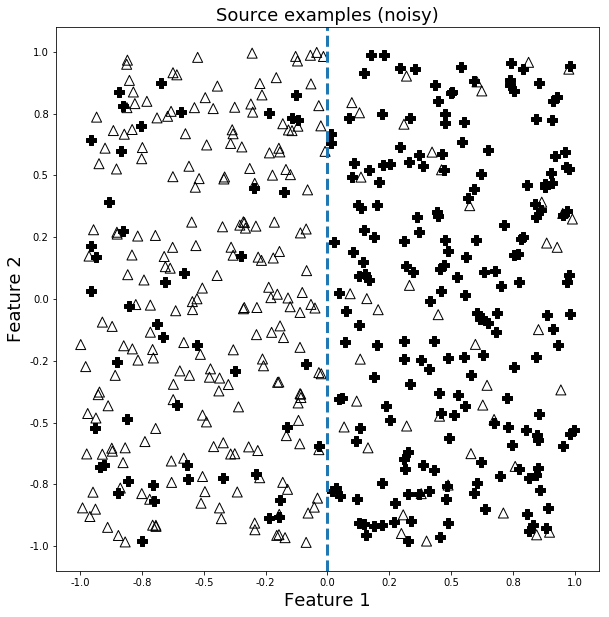

In [14]:
d = train_loader.dataset

from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
zeros_ind = np.where(d.labels == 0)
ones_ind = np.where(d.labels == 1)
ax.scatter(d.data[zeros_ind,0], d.data[zeros_ind,1], marker="^", edgecolors='black', facecolors='none', s=100.0 )
ax.scatter(d.data[ones_ind,0], d.data[ones_ind,1], marker="P", edgecolors='black', facecolors='black', s=100.0 )
ax.axis('equal')
ax.plot([0,0], [-1.1,1.1], linestyle='--', linewidth=3)
ax.set_title('Source examples (noisy)', fontsize=18)
plt.xlabel('Feature 1', fontsize=18)
plt.ylabel('Feature 2', fontsize=18)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')
# plt.draw()
# plt.show()



plt.savefig(SAVE_PATH+'/raw_input.pdf')

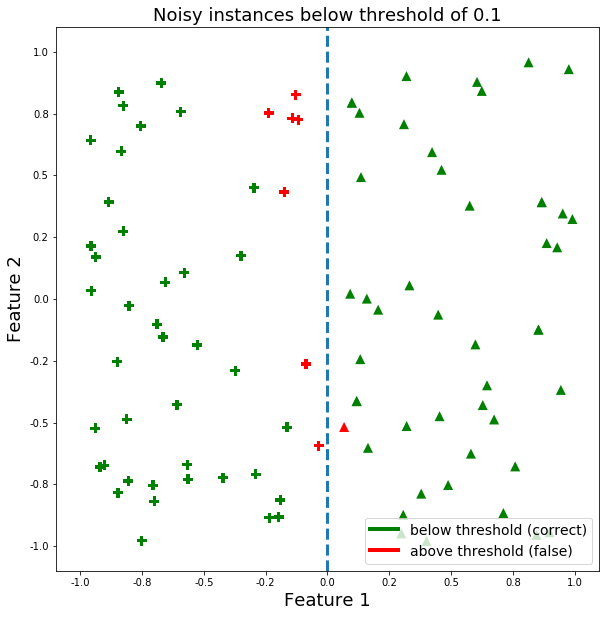

In [10]:
# which noisy point is below threshold
zeros_ind = np.where(d.labels[d.rand_ind] == 0)
ones_ind = np.where(d.labels[d.rand_ind] == 1)

c_zeros = (a_list[-1][d.rand_ind[zeros_ind]] < 0.1).astype(int)
c_zeros = [['red', 'green'][x] for x in c_zeros]
c_ones = (a_list[-1][d.rand_ind[ones_ind]] < 0.1).astype(int)
c_ones = [['red', 'green'][x] for x in c_ones]

# below_treshold = (a_list[-1][d.rand_ind] < 0.1).astype(int)
# above_treshold = (a_list[-1][d.rand_ind] >= 0.1).astype(int)

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.scatter(d.data[d.rand_ind[zeros_ind],0], d.data[d.rand_ind[zeros_ind],1], marker="^", edgecolors='none', c=c_zeros, s=100.0 )
ax.scatter(d.data[d.rand_ind[ones_ind],0], d.data[d.rand_ind[ones_ind],1], marker="P", edgecolors='none', c=c_ones, s=100.0 )


# ax.scatter(d.data[d.rand_ind,0], d.data[d.rand_ind,1], s=100.0, c=below_treshold, alpha=0.8)

ax.axis('equal')
ax.plot([0,0], [-1.1,1.1], linestyle='--', linewidth=3)
ax.set_title('Noisy instances below threshold of {:.1f}'.format(0.1), fontsize=18)
plt.xlabel('Feature 1', fontsize=18)
plt.ylabel('Feature 2', fontsize=18)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')

#
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='g', lw=4, label='below threshold (correct)'),
                   Line2D([0], [0], color='r', lw=4, label='above threshold (false)')]                   

# Create the figure
ax.legend(handles=legend_elements, loc='lower right', prop={'size': 14})


# plt.draw()
# plt.show()

plt.savefig(SAVE_PATH+'noisy_below_thresh.pdf')

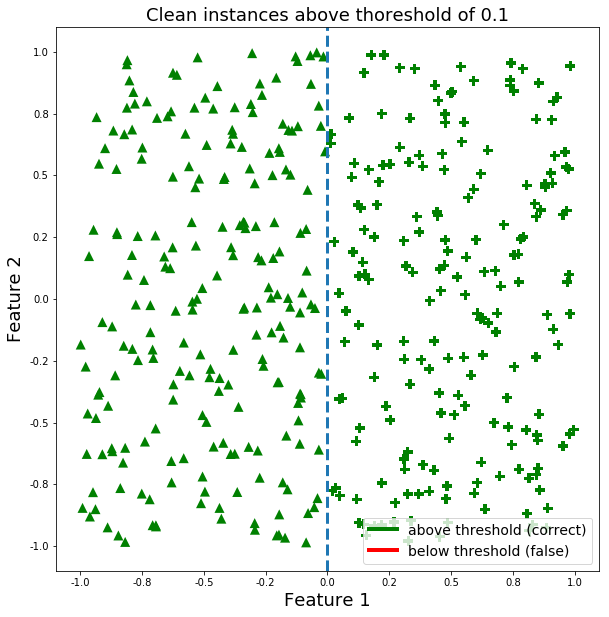

In [11]:
# which *clean point* is below threshold
clean_ind = np.setdiff1d(range(d.npts_src), d.rand_ind)
zeros_ind = np.where(d.labels[clean_ind] == 0)
ones_ind = np.where(d.labels[clean_ind] == 1)

c_zeros = (a_list[-1][clean_ind[zeros_ind]] >= 0.1).astype(int)
c_zeros = [['red', 'green'][x] for x in c_zeros]
c_ones = (a_list[-1][clean_ind[ones_ind]] >= 0.1).astype(int)
c_ones = [['red', 'green'][x] for x in c_ones]


# below_treshold = (a_list[-1][clean_ind] < 0.1).astype(int)

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.scatter(d.data[clean_ind[zeros_ind],0], d.data[clean_ind[zeros_ind],1], marker="^", edgecolors='none', c=c_zeros, s=100.0 )
ax.scatter(d.data[clean_ind[ones_ind],0], d.data[clean_ind[ones_ind],1], marker="P", edgecolors='none', c=c_ones, s=100.0 )

# ax.scatter(d.data[clean_ind,0], d.data[clean_ind,1], s=100.0, c=below_treshold, alpha=0.8)

ax.axis('equal')
ax.plot([0,0], [-1.1,1.1], linestyle='--', linewidth=3)
ax.set_title('Clean instances above thoreshold of {:.1f}'.format(0.1), fontsize=18)
plt.xlabel('Feature 1', fontsize=18)
plt.ylabel('Feature 2', fontsize=18)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal', adjustable='box')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='g', lw=4, label='above threshold (correct)'),
                   Line2D([0], [0], color='r', lw=4, label='below threshold (false)')]   

ax.legend(handles=legend_elements, loc='lower right', prop={'size': 14})
# plt.draw()
# plt.show()

plt.savefig(SAVE_PATH+'clean_above_thresh.pdf')

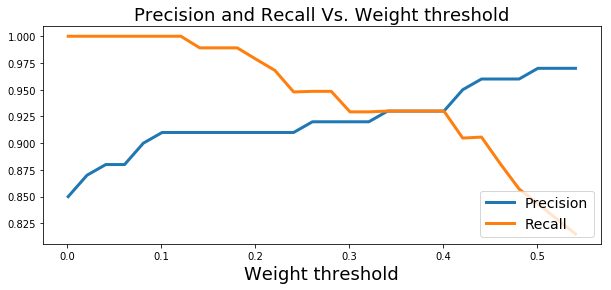

In [12]:
from scipy.interpolate import interp1d


prec = []
rcl = []
# p_clean = []
th_range = np.arange(0.001, 0.55, 0.001) 
for th in th_range:
    noisy_examples_below_treshold = (a_list[-1][d.rand_ind] < th).astype(int).sum()    
    clean_examples_below_treshold = (a_list[-1][clean_ind] < th).astype(int).sum()
    
    prec.append(1.0 * noisy_examples_below_treshold / (1e-6 + noisy_examples_below_treshold + clean_examples_below_treshold))
    rcl.append(1.0 * noisy_examples_below_treshold / len(d.rand_ind) )



    
fig, ax = plt.subplots()
fig.set_figwidth(10)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))


prec = interp1d(th_range, prec, kind='cubic')
rcl = interp1d(th_range, rcl, kind='cubic')
xnew = th_range[::20]
ax.plot(xnew, rcl(xnew), linewidth=3)
ax.plot(xnew, prec(xnew), linewidth=3)
ax.set_title('Precision and Recall Vs. Weight threshold', fontsize=18)
plt.xlabel('Weight threshold', fontsize=18)
plt.legend(['Precision', 'Recall'], loc='lower right', prop={'size': 14})
# plt.xlim(-1.1, 1.1)
# plt.ylim(-1.1, 1.1)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.draw()
# plt.show()    


plt.savefig(SAVE_PATH+'precision_recall.pdf')    

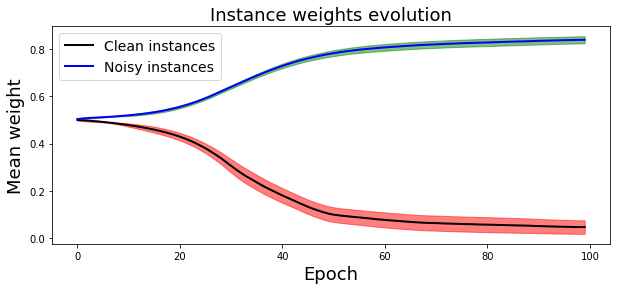

In [13]:
from scipy.stats import sem

def calc_conf(samples, ind):
    
    mean_ = [x[ind].mean() for x in samples]
    
    conf_ = [1.96 * sem(x[ind]) for x in samples]

    y = [(a-b, a+b) for a,b in zip(mean_, conf_)]

    y1, y2 = zip(*y)
    return mean_, y1, y2


n_mean, n_y1, n_y2 = calc_conf(a_list, d.rand_ind)

clean_ind = np.setdiff1d(range(d.npts_src), d.rand_ind)
c_mean, c_y1, c_y2 = calc_conf(a_list, clean_ind)

fig, ax = plt.subplots()
fig.set_figwidth(10)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_title('Instance weights evolution', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Mean weight', fontsize=18)
plt.plot(n_mean, color='black', linewidth=2)
plt.fill_between(range(len(a_list)), n_y1, n_y2, color='r', alpha=0.5)

plt.plot(c_mean, color='blue', linewidth=2)
plt.fill_between(range(len(a_list)), c_y1, c_y2, color='g', alpha=0.5)

plt.legend(['Clean instances', 'Noisy instances'], prop={'size': 14})


# plt.draw()
# plt.show()

plt.savefig(SAVE_PATH+'weight_evolution.pdf')